<p align = "center" draggable=”false” ><img src="https://github.com/AI-Maker-Space/LLM-Dev-101/assets/37101144/d1343317-fa2f-41e1-8af1-1dbb18399719" 
     width="200px"
     height="auto"/>
</p>

<h1 align="center" id="heading">OpenAI Agents SDK - AIM</h1>

In this notebook, we'll go over some of the key features of the OpenAI Agents SDK - as explored through a notebook-ified version of their [Research Bot](https://github.com/openai/openai-agents-python/tree/main/examples/research_bot).

In [1]:
### You don't need to run this cell if you're running this notebook locally. 

#!pip install -qU openai-agents

API Key:

In [2]:
import os 
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass()

Nest Async:

In [3]:
import nest_asyncio
nest_asyncio.apply()

## Agents

As may be expected, the primary thing we'll do in the Agents SDK is construct Agents!

Agents are constructed with a few basic properties:

- A prompt, which OpenAI is using the language "instruction" for, that determines the behaviour or goal of the Agent
- A model, the "brain" of the Agent

They also typically include an additional property: 

- Tool(s) that equip the Agent with things it can use to get stuff done

### Task 1: Create Planner Agent

Let's start by creating our "Planner Agent" - which will come up with the initial set of search terms that should answer a query provided by the user. 



In [4]:
from pydantic import BaseModel
from agents import Agent

PLANNER_PROMPT = (
    "You are a helpful research assistant. Given a query, come up with a set of web searches to perform" 
    "to best answer the query. Output between 5 and 20 terms to query for."
)

Next, we'll define the data models that our Planner Agent will use to structure its output. We'll create:

1. `WebSearchItem` - A model for individual search items, containing the search query and reasoning
2. `WebSearchPlan` - A container model that holds a list of search items

These Pydantic models will help ensure our agent returns structured data that we can easily process.


In [5]:
class WebSearchItem(BaseModel):
    reason: str
    "Your reasoning for why this search is important to the query."

    query: str
    "The search term to use for the web search."

class WebSearchPlan(BaseModel):
    searches: list[WebSearchItem]
    """A list of web searches to perform to best answer the query."""

Now we'll create our Planner Agent using the Agent class from the OpenAI Agents SDK. This agent will use the instructions defined in `PLANNER_PROMPT` and will output structured data in the form of our WebSearchPlan model. We're using the GPT-4o model for this agent to ensure high-quality search term generation.

> NOTE: When we provide an `output_type` - the model will return a [structured response](https://platform.openai.com/docs/guides/structured-outputs?api-mode=responses).


In [6]:
planner_agent = Agent(
    name="PlannerAgent",
    instructions=PLANNER_PROMPT,
    model="gpt-4.1",
    output_type=WebSearchPlan,
)

#### ❓Question #1:

Why is it important to provide a structured response template? (As in: Why are structured outputs helpful/preferred in Agentic workflows?)

**Answer:**  In agentic AI applications, giving a structured response template is important because it helps the whole system stay organized and predictable, kind of like giving clear directions to a team member. When AI agents work together or with tools, they need to know exactly what to expect from each other’s responses. If the output is messy or inconsistent, it’s like trying to work with someone who mumbles you’ll spend too much time guessing what they meant.

Structured outputs make it easier for other agents, tools, or downstream processes to pick up the result and act on it without confusion, So in short: structured responses reduce ambiguity, improve collaboration between agents, and help make decisions faster and more reliably. It’s like making sure everyone in a team is speaking the same language.

### Task 2: Create Search Agent

Now we'll create our Search Agent, which will be responsible for executing web searches based on the terms generated by the Planner Agent. This agent will take each search query, perform a web search using the `WebSearchTool`, and then summarize the results in a concise format.

> NOTE: We are using the `WebSearchTool`, a hosted tool that can be used as part of an `OpenAIResponsesModel` as outlined in the [documentation](https://openai.github.io/openai-agents-python/tools/). This is based on the tools available through OpenAI's new [Responses API](https://openai.com/index/new-tools-for-building-agents/).

The `SEARCH_PROMPT` below instructs the agent to create brief, focused summaries of search results. These summaries are designed to be 2-3 paragraphs, under 300 words, and capture only the essential information without unnecessary details. The goal is to provide the Writer Agent with clear, distilled information that can be efficiently synthesized into the final report.


In [7]:
SEARCH_PROMPT = (
    "You are a research assistant. Given a search term, you search the web for that term and"
    "produce a concise summary of the results. The summary must 2-3 paragraphs and less than 300"
    "words. Capture the main points. Write succinctly, no need to have complete sentences or good"
    "grammar. This will be consumed by someone synthesizing a report, so its vital you capture the"
    "essence and ignore any fluff. Do not include any additional commentary other than the summary"
    "itself."
)

Now we'll create our Search Agent using the Agent class from the OpenAI Agents SDK. This agent will use the instructions defined in `SEARCH_PROMPT` and will utilize the `WebSearchTool` to perform web searches. We're configuring it with `tool_choice="required"` to ensure it always uses the search tool when processing requests.

> NOTE: We can, as demonstrated, indicate how we want our model to use tools. You can read more about that at the bottom of the page [here](https://openai.github.io/openai-agents-python/agents/)

In [8]:
from agents import WebSearchTool
from agents.model_settings import ModelSettings

search_agent = Agent(
    name="Search agent",
    instructions=SEARCH_PROMPT,
    tools=[WebSearchTool()],
    model_settings=ModelSettings(tool_choice="required"),
)

#### ❓ Question #2: 

What other tools are supported in OpenAI's Responses API?  
**Answer:**   
**Web Search**   
Enables AI agents to retrieve real-time information from the internet, ensuring responses are up-to-date and grounded in current data.  
  
**File Search**  
Allows agents to search through and extract relevant information from documents, making it useful for tasks like customer support or legal research.  
  
**Computer Use**  
Empowers agents to perform tasks on a user's behalf, such as filling out forms or scheduling appointments, by simulating user interactions with a computer.  
   
**Function Calling**    
Enables agents to execute predefined functions or APIs, allowing for dynamic interactions and integrations with other services.  

### Task 3: Create Writer Agent

Finally, we'll create our Writer Agent, which will synthesize all the research findings into a comprehensive report. This agent takes the original query and the research summaries from the Search Agent, then produces a structured report with follow-up questions.

The Writer Agent will:
1. Create an outline for the report structure
2. Generate a detailed markdown report (5-10 pages)
3. Provide follow-up questions for further research

We'll define the prompt for this agent in the next cell. This prompt will instruct the Writer Agent on how to synthesize research findings into a comprehensive report with follow-up questions.

In [9]:
WRITER_PROMPT = (
    "You are a senior researcher tasked with writing a cohesive report for a research query. "
    "You will be provided with the original query, and some initial research done by a research "
    "assistant.\n"
    "You should first come up with an outline for the report that describes the structure and "
    "flow of the report. Then, generate the report and return that as your final output.\n"
    "The final output should be in markdown format, and it should be lengthy and detailed. Aim "
    "for 5-10 pages of content, at least 1000 words.\n"
    "For the follow-up questions, provide exactly 5 unique questions that would help extend "
    "this research. Do not repeat questions."
)

#### 🏗️ Activity #1: 

This prompt is quite generic - modify this prompt to produce a report that is more personalized to either your personal preference, or more appropriate for a specific use case (eg. law domain research)

Now we'll create our Writer Agent using the Agent class from the OpenAI Agents SDK. This agent will synthesize all the research findings into a comprehensive report. We're configuring it with the `ReportData` output type to structure the response with a short summary, markdown report, and follow-up questions.

In [10]:
class ReportData(BaseModel):
    short_summary: str
    """A short 2-3 sentence summary of the findings."""

    markdown_report: str
    """The final report"""

    follow_up_questions: list[str]
    """Suggested topics to research further"""

Now we'll define our Writer Agent using the Agent class from the OpenAI Agents SDK. This agent will take the original query and research summaries, then synthesize them into a comprehensive report with follow-up questions. We've defined a custom output type called `ReportData` that structures the response with a short summary, markdown report, and follow-up questions.

In [11]:
writer_agent = Agent(
    name="WriterAgent",
    instructions=WRITER_PROMPT,
    model="o3-mini",
    output_type=ReportData,
)

#### ❓ Question #3: 

Why are we electing to use a reasoning model for writing our report?
**Answer:**    
**1. They go beyond surface-level facts**  
Reasoning models can analyze complex information, draw logical conclusions, and explain why something matters — which is crucial in a research report where depth and clarity are key.  
  
**2. They help structure arguments**    
Writing a research report involves laying out claims, backing them up with evidence, and presenting a clear line of thought. A reasoning model is trained to follow this process, making the output coherent and persuasive.  
  
**3. They connect the dots**  
Often, research requires synthesizing information from multiple sources. A reasoning model can combine insights, compare findings, and highlight relationships — something basic retrieval models or static templates can’t do well.  
  
**4. They adapt to the context**  
Whether it's scientific, social, or technical research, reasoning models can tailor their writing style, tone, and depth based on the topic, audience, and objective.  

## Task 4: Create Utility Classes 

We'll define utility classes to help with displaying progress and managing the research workflow. The Printer class below will provide real-time updates on the research process.


The Printer class provides real-time progress updates during the research process. It uses Rich's Live display to show dynamic content with spinners for in-progress items and checkmarks for completed tasks. The class maintains a dictionary of items with their completion status and can selectively hide checkmarks for specific items. This creates a clean, interactive console experience that keeps the user informed about the current state of the research workflow.

In [12]:
from typing import Any

from rich.console import Console, Group
from rich.live import Live
from rich.spinner import Spinner

class Printer:
    def __init__(self, console: Console):
        self.live = Live(console=console)
        self.items: dict[str, tuple[str, bool]] = {}
        self.hide_done_ids: set[str] = set()
        self.live.start()

    def end(self) -> None:
        self.live.stop()

    def hide_done_checkmark(self, item_id: str) -> None:
        self.hide_done_ids.add(item_id)

    def update_item(
        self, item_id: str, content: str, is_done: bool = False, hide_checkmark: bool = False
    ) -> None:
        self.items[item_id] = (content, is_done)
        if hide_checkmark:
            self.hide_done_ids.add(item_id)
        self.flush()

    def mark_item_done(self, item_id: str) -> None:
        self.items[item_id] = (self.items[item_id][0], True)
        self.flush()

    def flush(self) -> None:
        renderables: list[Any] = []
        for item_id, (content, is_done) in self.items.items():
            if is_done:
                prefix = "✅ " if item_id not in self.hide_done_ids else ""
                renderables.append(prefix + content)
            else:
                renderables.append(Spinner("dots", text=content))
        self.live.update(Group(*renderables))

Let's create a ResearchManager class that will orchestrate the research process. This class will:
1. Plan searches based on the query
2. Perform those searches to gather information
3. Write a comprehensive report based on the gathered information
4. Display progress using our Printer class


In [13]:
from __future__ import annotations

import asyncio
import time

from agents import Runner, custom_span, gen_trace_id, trace

class ResearchManager:
    def __init__(self):
        self.console = Console()
        self.printer = Printer(self.console)

    async def run(self, query: str) -> None:
        trace_id = gen_trace_id()
        with trace("Research trace", trace_id=trace_id):
            self.printer.update_item(
                "trace_id",
                f"View trace: https://platform.openai.com/traces/trace?trace_id={trace_id}",
                is_done=True,
                hide_checkmark=True,
            )

            self.printer.update_item(
                "starting",
                "Starting research...",
                is_done=True,
                hide_checkmark=True,
            )
            search_plan = await self._plan_searches(query)
            search_results = await self._perform_searches(search_plan)
            report = await self._write_report(query, search_results)

            final_report = f"Report summary\n\n{report.short_summary}"
            self.printer.update_item("final_report", final_report, is_done=True)

            self.printer.end()

        print("\n\n=====REPORT=====\n\n")
        print(f"Report: {report.markdown_report}")
        print("\n\n=====FOLLOW UP QUESTIONS=====\n\n")
        unique_questions = []
        seen = set()
        
        for question in report.follow_up_questions:
            if question not in seen:
                unique_questions.append(question)
                seen.add(question)
        
        for i, question in enumerate(unique_questions, 1):
            print(f"{i}. {question}")

    async def _plan_searches(self, query: str) -> WebSearchPlan:
        self.printer.update_item("planning", "Planning searches...")
        result = await Runner.run(
            planner_agent,
            f"Query: {query}",
        )
        self.printer.update_item(
            "planning",
            f"Will perform {len(result.final_output.searches)} searches",
            is_done=True,
        )
        return result.final_output_as(WebSearchPlan)

    async def _perform_searches(self, search_plan: WebSearchPlan) -> list[str]:
        with custom_span("Search the web"):
            self.printer.update_item("searching", "Searching...")
            num_completed = 0
            max_concurrent = 5
            results = []
            
            for i in range(0, len(search_plan.searches), max_concurrent):
                batch = search_plan.searches[i:i+max_concurrent]
                tasks = [asyncio.create_task(self._search(item)) for item in batch]
                
                for task in asyncio.as_completed(tasks):
                    try:
                        result = await task
                        if result is not None:
                            results.append(result)
                    except Exception as e:
                        print(f"Search error: {e}")
                        
                    num_completed += 1
                    self.printer.update_item(
                        "searching", f"Searching... {num_completed}/{len(search_plan.searches)} completed"
                    )
            
            self.printer.mark_item_done("searching")
            return results

    async def _search(self, item: WebSearchItem) -> str | None:
        input = f"Search term: {item.query}\nReason for searching: {item.reason}"
        try:
            result = await Runner.run(
                search_agent,
                input,
            )
            return str(result.final_output)
        except Exception as e:
            print(f"Error searching for '{item.query}': {e}")
            return None

    async def _write_report(self, query: str, search_results: list[str]) -> ReportData:
        self.printer.update_item("writing", "Thinking about report...")
        input = f"Original query: {query}\nSummarized search results: {search_results}"
        
        result = Runner.run_streamed(
            writer_agent,
            input,
        )
        
        update_messages = [
            "Thinking about report...",
            "Planning report structure...",
            "Writing outline...",
            "Creating sections...",
            "Cleaning up formatting...",
            "Finalizing report...",
            "Finishing report...",
        ]

        last_update = time.time()
        next_message = 0
        
        async for event in result.stream_events():
            if time.time() - last_update > 5 and next_message < len(update_messages):
                self.printer.update_item("writing", update_messages[next_message])
                next_message += 1
                last_update = time.time()

        self.printer.mark_item_done("writing")
        return result.final_output_as(ReportData)

#### 🏗️ Activity #2:

Convert the above flow into a flowchart style image (software of your choosing, but if you're not sure which to use try [Excallidraw](https://excalidraw.com/)) that outlines how the different Agents interact with each other. 


> HINT: Cursor's CMD+L (CTRL+L on Windows) would be a helpful way to get a basic diagram that you can add more detail to!

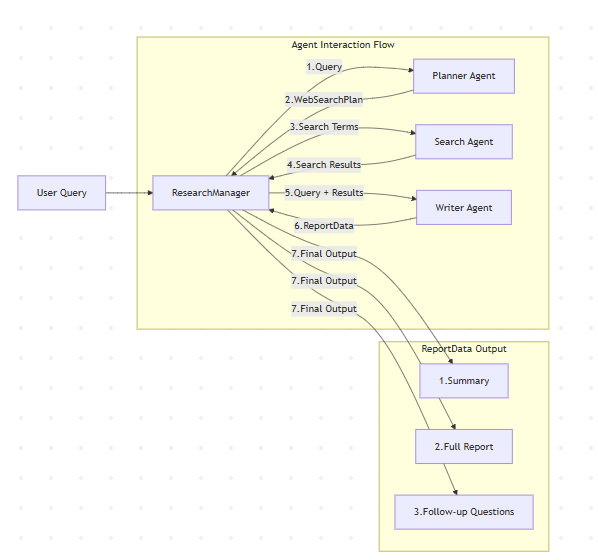

In [14]:
from IPython.display import Image, display
# Display the image
display(Image(filename='images/agent_handoff_flow.png'))

1. ResearchManager is the central orchestrator  
2. Each agent interaction is handled sequentially by the ResearchManager  
The flow is:  
    * Planner Agent generates WebSearchPlan  
    * Search Agent processes search terms in batches (max 5 concurrent)  
    * Writer Agent generates ReportData  
    * ResearchManager formats and displays the final output  
3. This diagram better reflects the actual code implementation where:  
    * ResearchManager controls the flow between agents  
    * Each agent's output is processed by ResearchManager before being passed to the next agent  
    * The final output is structured into three parts from the ReportData model  

## Task 5: Running Our Agent

Now let's run our agent! The main function below will prompt the user for a research topic, then pass that query to our ResearchManager to handle the entire research process. The ResearchManager will: 

1. Break down the query into search items
2. Search for information on each item
3. Write a comprehensive report based on the search results

Let's see it in action!

In [15]:
async def main() -> None:
    query = input("Report on OpenAI Agent SDK) ")
    await ResearchManager().run(query)

In [16]:
asyncio.run(main())

Output()



=====REPORT=====


Report: # Handling Empty Search Queries: A Comprehensive Analysis

## Table of Contents

1. [Introduction](#introduction)
2. [The Significance of Empty Queries](#the-significance-of-empty-queries)
3. [Empty Search Behavior Across Popular Platforms](#empty-search-behavior-across-popular-platforms)
   - 3.1 [Google and Its Easter Eggs](#google-and-its-easter-eggs)
   - 3.2 [Default Responses in Google Search](#default-responses-in-google-search)
   - 3.3 [Case Studies: Algolia, WordPress, and MeiliSearch](#case-studies-algolia-wordpress-and-meilisearch)
4. [User Experience Considerations](#user-experience-considerations)
5. [Technical Implementations and Design Strategies](#technical-implementations-and-design-strategies)
6. [Discussion](#discussion)
7. [Conclusions](#conclusions)
8. [References and Further Reading](#references-and-further-reading)

## Introduction

In the modern digital era, the search functionality within applications and websites has become a crit

---

## Sample Report in Markdown 

---

# OpenAI Agents SDK: A Comprehensive Report

*Published: October 2023*

## Table of Contents

1. [Introduction](#introduction)
2. [Core Concepts and Key Features](#core-concepts-and-key-features)
3. [Architecture and Developer Experience](#architecture-and-developer-experience)
4. [Comparative Analysis with Alternative Frameworks](#comparative-analysis-with-alternative-frameworks)
5. [Integrations and Real-World Applications](#integrations-and-real-world-applications)
6. [Troubleshooting, Observability, and Debugging](#troubleshooting-observability-and-debugging)
7. [Community Impact and Future Directions](#community-impact-and-future-directions)
8. [Conclusion](#conclusion)

---

## Introduction

In March 2025, OpenAI released the Agents SDK, a groundbreaking, open-source framework aimed at simplifying the development of autonomous AI agents capable of performing intricate tasks with minimal human intervention. Designed with a Python-first approach, the SDK offers a minimal set of abstractions, yet provides all the necessary components to build, debug, and optimize multi-agent workflows. The release marked a significant milestone for developers who seek to integrate large language models (LLMs) with advanced task delegation mechanisms, enabling next-generation automation in various industries.

The primary goal of the OpenAI Agents SDK is to streamline the creation of agentic applications by offering core primitives such as *agents*, *handoffs*, and *guardrails*. These primitives are essential for orchestrating autonomous AI systems that perform key functions such as web search, file operations, and even actions on a computer. This report delves into the SDK's features, its operational architecture, integration capabilities, and how it compares to other frameworks in the rapidly evolving landscape of AI development tools.

## Core Concepts and Key Features

### Agents

At the heart of the SDK are **agents**—intelligent entities that encapsulate a specific set of instructions and tools. Each agent is built on top of a large language model and can be customized with its own personality, domain expertise, and operational directives. For example, a "Math Tutor" agent could be designed to solve math problems by explaining each step clearly.

**Key elements of an agent include:**

- **Instructions:** Specific guidelines that shape the agent's responses and behavior in the context of its designated role.
- **Tools:** Predefined or dynamically integrated tools that the agent can leverage to access external resources (e.g., web search or file search functionalities).

### Handoffs

A unique feature introduced by the SDK is the concept of **handoffs**. Handoffs allow agents to delegate tasks to one another based on expertise and contextual needs. This orchestration paves the way for sophisticated workflows where multiple agents work in tandem, each contributing its specialized capabilities to complete a complex task.

### Guardrails

Safety and reliability remain a cornerstone in AI development, and the SDK introduces **guardrails** as a means of controlling input and output validation. Guardrails help ensure that agents operate within defined safety parameters, preventing unintended actions and mitigating risks associated with autonomous decision-making.

### Built-in Debugging and Observability

The development process is further enhanced by built-in **tracing and visualization tools**. These tools offer real-time insights into agent interactions, tool invocations, and decision-making pathways, thereby making debugging and optimization more accessible and systematic. The tracing functionality is a vital feature for developers looking to fine-tune agent performance in production environments.

## Architecture and Developer Experience

### Python-First Approach

The SDK is inherently Python-based, making it highly accessible to the vast community of Python developers. By leveraging existing language features without introducing excessive abstractions, the SDK provides both simplicity and power. The installation is straightforward:

```bash
mkdir my_project
cd my_project
python -m venv .venv
source .venv/bin/activate
pip install openai-agents
```

Once installed, developers can create and configure agents with minimal boilerplate code. The emphasis on a minimal learning curve has been a significant point of praise among early adopters.

### Developer Tools and Tutorials

In addition to comprehensive official documentation available on OpenAI’s GitHub pages, the community has contributed numerous tutorials and code examples. Video tutorials by experts such as Sam Witteveen and James Briggs provide hands-on demonstrations, ranging from simple agent creation to more sophisticated scenarios involving parallel execution and advanced tool integrations.

### Use of Python's Ecosystem

The integration with Python’s ecosystem means that developers can immediately apply a range of established libraries and frameworks. For instance, utilizing Pydantic for input validation in guardrails or leveraging visualization libraries to display agent workflows are examples of how the SDK embraces the strengths of Python.

## Comparative Analysis with Alternative Frameworks

While the OpenAI Agents SDK has received acclaim for its simplicity and robust integration with OpenAI’s ecosystem, other frameworks such as LangGraph, CrewAI, and AutoGen have emerged as viable alternatives. Here’s how they compare:

- **LangGraph:** Known for its graph-based architecture, LangGraph is ideal for handling complex and cyclical workflows that require sophisticated state management. However, it comes with a steeper learning curve, making it less accessible for projects that require quick prototyping.

- **CrewAI:** Emphasizing a role-based multi-agent system, CrewAI excels in scenarios where collaboration among agents is critical. Its design promotes clear segregation of duties among different agents, which can be beneficial in customer service or large-scale business automation.

- **AutoGen:** This framework supports flexible conversation patterns and diverse agent interactions, particularly useful in applications where adaptive dialogue is essential. Nevertheless, AutoGen may introduce additional overhead when managing state and coordinating multiple agents.

In contrast, the OpenAI Agents SDK strikes an effective balance by offering a lightweight yet powerful toolset geared towards production readiness. Its strengths lie in its minimal abstractions, ease of integration with various tools (like web search and file search), and built-in observability features that are crucial for debugging and tracing agent interactions.

## Integrations and Real-World Applications

### Diverse Integrations

The real power of the OpenAI Agents SDK surfaces when it is integrated with other systems and platforms. Notable integrations include:

- **Box Integration:** Enhancing enterprise content management, Box has adopted the SDK to enable secure AI-powered data processing. This integration allows agents to reliably access and interpret proprietary data.

- **Coinbase AgentKit:** With financial capabilities in mind, Coinbase introduced AgentKit, leveraging the SDK to incorporate financial operations and risk analysis directly into AI agents.

- **Milvus and Ollama:** These integrations allow the SDK to handle high-performance data queries and run agents on local infrastructure respectively, ensuring both speed and privacy.

### Real-World Applications

The versatility of the SDK lends itself to a multitude of applications:

- **Customer Support:** Automated agents can be built to handle customer inquiries, providing faster and more accurate responses while reducing workload on human agents.

- **Content Generation:** In marketing and media, agents can generate high-quality articles, detailed reports, and even code reviews with built-in content guidelines.

- **Financial Analysis:** Specialized agents capable of real-time data fetching and market analysis can generate actionable insights for investors and analysts.

- **Health and Wellness:** Custom agents can handle tasks such as appointment scheduling, patient record management, and even provide personalized fitness and dietary recommendations.

- **Educational Tools:** Intelligent tutoring agents can assist students by providing personalized learning experiences and instant feedback on assignments.

These applications underscore the SDK’s transformative potential across various industries, driving the trend towards increased automation and efficiency.

## Troubleshooting, Observability, and Debugging

### Common Issues and Solutions

As with any cutting-edge technology, developers working with the OpenAI Agents SDK have encountered challenges:

- **API Key Management:** Authentication errors due to missing or invalid API keys are common. The solution involves ensuring that the `OPENAI_API_KEY` environment variable is correctly set or programmatically configured using OpenAI’s helper functions.

- **Rate Limitations:** Rate limits, an intrinsic challenge with API-based services, require developers to monitor dashboard usage and implement retry strategies with exponential backoff.

- **Response Delays:** Network latency and high server loads can result in unexpected delays. Developers are advised to check network settings, adhere to best practices in setting request timeouts, and monitor OpenAI’s service status.

### Built-In Tracing Capabilities

The SDK provides robust tracing tools that log agent inputs, outputs, tool interactions, and error messages. This level of observability is crucial for debugging complex workflows and allows developers to visualize the agent’s decision-making process in real time. By configuring a `TracingConfig` object, developers can capture detailed insights and identify performance bottlenecks.

### Best Practices

- **Prompt Engineering:** Refine prompts to reduce ambiguity and minimize unexpected outputs.
- **Layered Validation:** Use guardrails extensively to ensure inputs and outputs are verified at multiple layers.
- **Modular Design:** Break complex tasks into smaller, more manageable components using handoffs to delegate tasks appropriately.

## Community Impact and Future Directions

### Developer and Enterprise Adoption

The release of the OpenAI Agents SDK has been met with enthusiasm within the developer community. Its ease of use, combined with comprehensive documentation and community-driven resources (such as tutorials on Class Central and DataCamp), has accelerated its adoption across educational, enterprise, and research sectors.

Several leading organizations, including Box and Coinbase, have integrated the SDK into their workflows, demonstrating its capability to drive real-world business solutions. The open-source nature of the SDK, licensed under the MIT License, further encourages widespread industrial collaboration and innovation.

### Future Prospects

Looking forward, OpenAI plans to extend the SDK’s support beyond Python, potentially embracing other programming languages like JavaScript. Additionally, future updates are anticipated to expand tool integrations, further enhance safety mechanisms, and streamline the development of multi-agent ecosystems. Planned deprecations of older APIs, such as the Assistants API in favor of the more unified Responses API, underline the SDK’s evolving roadmap aimed at future-proofing agentic applications.

## Conclusion

The OpenAI Agents SDK represents a significant step forward in the field of AI development. Its lightweight, Python-first framework facilitates the creation of autonomous agents that can handle a wide array of tasks—from simple inquiries to complex multi-agent systems. The SDK’s robust integration capabilities, combined with its focus on safety and observability, make it an ideal choice for both developers and enterprises seeking to build reliable, scalable agentic applications.

In summary, the SDK not only lowers the barrier to entry for developing sophisticated AI applications but also sets the stage for further innovations as the ecosystem evolves. It is poised to become a standard toolkit for the next generation of AI-driven technologies, empowering users across sectors to achieve greater efficiency and creativity in task automation.

---

*For further reading, developers are encouraged to visit the official OpenAI documentation, join the community forums, and explore real-world use cases to deepen their understanding of this transformative tool.*